In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from collections import defaultdict
from datetime import datetime
import h5py
import matplotlib.pyplot as plt
from neural_analysis.matIO import loadmat
import numpy as np
import os
import pandas as pd
import re
from scipy.signal import butter, filtfilt, freqz
import shutil
import sys
import time
from tqdm.auto import tqdm

sys.path.append('../../..')
from ld_utils import compute_eigs, get_data_sigma_norms
from plot import plot_individual_areas, plot_multipopulation
from up_down import get_up_down
from utils import compile_folder, get_data_class, get_result_path, load, save

In [4]:
## propofolPuffTone
session = 'Mary-Anesthesia-20160809-01'
# session = 'MrJones-Anesthesia-20160105-01'
# session = 'Mary-Anesthesia-20160916-02'
# session = 'MrJones-Anesthesia-20160301-01'
# session = 'MrJones-Anesthesia-20160113-01'
# session = 'Mary-Anesthesia-20160818-02'
# session = 'MrJones-Anesthesia-20160121-01'

## propofolWakeup
# session = 'Mary-Anesthesia-20170203-02'

## ketamine
# session = 'Mary-Anesthesia-20170315-01'
# session = 'MrJones-Anesthesia-20160805-01'
# session = 'MrJones-Anesthesia-20160808-01'
# session = 'Mary-Anesthesia-20170315-01'

## Load Neural Data

In [5]:
all_data_dir = f"/om/user/eisenaj/datasets/anesthesia/mat"
data_class = get_data_class(session, all_data_dir)

In [6]:
filename = os.path.join(all_data_dir, data_class, f'{session}.mat')
print("Loading data ...")
start = time.process_time()
electrode_info, lfp_schema, session_info, spike_times, trial_info, unit_info = loadmat(filename, variables=['electrodeInfo', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'trialInfo', 'unitInfo'], verbose=False)
spike_times = spike_times[0]
dt = lfp_schema['smpInterval'][0]
# T = lfp.shape[0]

print(f"Data loaded (took {time.process_time() - start:.2f} seconds)")

Loading data ...
Data loaded (took 5.20 seconds)


# Plot With Same Window

## Load Results

In [21]:
VAR_all_results_dir = f"/om/user/eisenaj/ChaoticConsciousness/results/{data_class}/VAR"
window = 5
stride = 5
VAR_results_dir = get_result_path(VAR_all_results_dir, session, window, stride)

In [22]:
VAR_results = {}
for file in tqdm(os.listdir(VAR_results_dir)):
    try:
        VAR_results[file] = load(os.path.join(VAR_results_dir, file))
    except IsADirectoryError:
        print(f"Need to compile {os.path.join(VAR_results_dir, file)}")
        # compile results
        VAR_results[file] = compile_folder(os.path.join(VAR_results_dir, file))

  0%|          | 0/5 [00:00<?, ?it/s]

# Plot

## Individual Areas

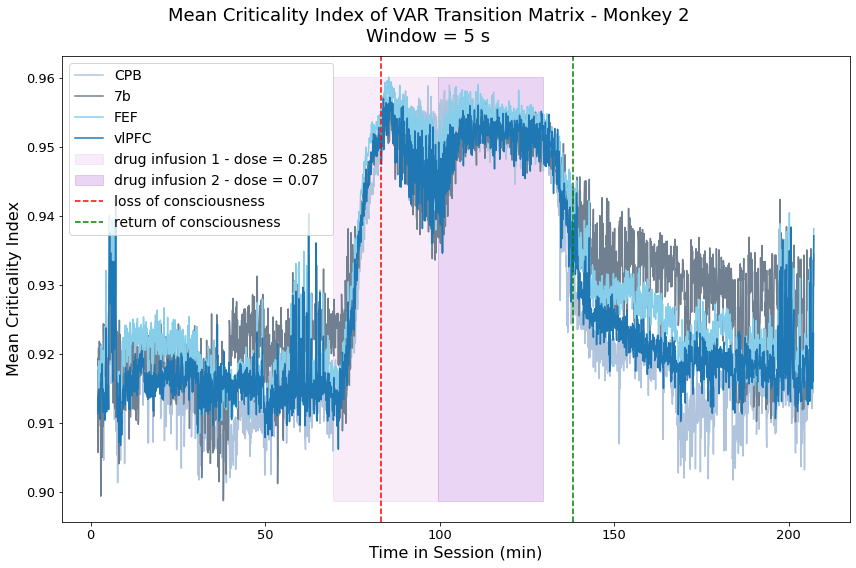

In [23]:
plot_individual_areas(session, data_class, VAR_results, window, stride, session_info, start_time=125, end_time=None)

## Multipopulation

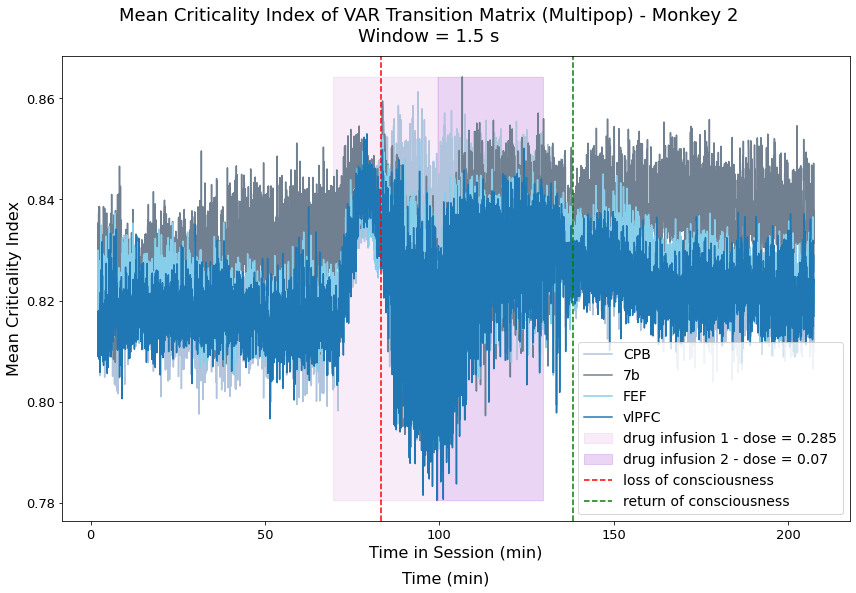

In [20]:
plot_multipopulation(session, data_class, VAR_results, window, stride, session_info, electrode_info, start_time=125, end_time=None)

## Criticality Distribution Single Area

In [12]:
area = 'all'

In [13]:
bin_nums = 20
bin_min = np.concatenate(VAR_results[area].criticality_inds.to_numpy()).min()
bin_min = 0.85
# bin_max = np.concatenate(VAR_results[area].criticality_inds.to_numpy()).max()
bin_max = 1.03
bins = [(bin_max - bin_min)*i/bin_nums + bin_min for i in range(bin_nums + 1 )]
criticality_prob_dist = np.zeros((VAR_results[area].criticality_inds.shape[0], bin_nums))
for t in range(VAR_results[area].criticality_inds.shape[0]):
    criticality_prob_dist[t] = np.histogram(VAR_results[area].criticality_inds[t], bins=bins)[0]

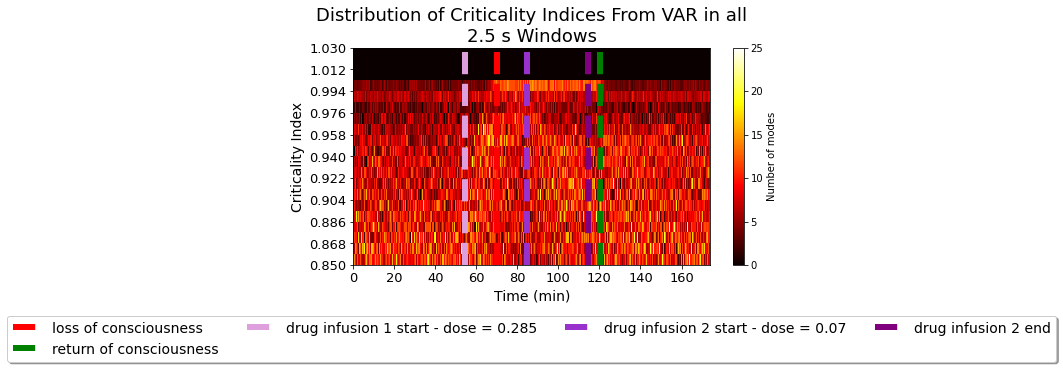

In [14]:
lw = 6
plt.figure(figsize=(8, 4))
plt.pcolormesh(criticality_prob_dist.T, cmap='hot')
start_times = np.arange(VAR_results[area].criticality_inds.shape[0])*stride/60
xticks = plt.xticks()
T_max = VAR_results[area].criticality_inds.shape[0]*stride/60
plt.xticks([int(i*60/stride) for i in np.arange(0, T_max, 20)], [int(i) for i in np.arange(0, T_max, 20)])
plt.yticks(np.arange(0, 21, 2), [f"{b:.3f}" for b in np.array(bins)[np.arange(0, 21, 2)]])
ax = plt.gca()
ax.tick_params(labelsize=13)
plt.xlabel("Time (min)", fontsize=14)
plt.ylabel("Criticality Index", fontsize=14)
plt.title(f"Distribution of Criticality Indices From VAR in {area}\n{window} s Windows", fontsize=18)
plt.axvline(session_info['eyesClose'][-1]/stride if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']/stride, linestyle='--', lw=lw, c='red', label="loss of consciousness")
plt.axvline(session_info['eyesOpen'][-1]/stride if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']/stride, linestyle='--', lw=lw, c='green', label="return of consciousness")
plt.axvline(session_info['drugStart'][0]/stride, color='plum', linestyle='--', lw=lw, label=f"drug infusion 1 start - dose = {session_info['drugDose'][0]}")
plt.axvline(session_info['drugStart'][1]/stride, color='darkorchid', linestyle='--', lw=lw, label=f"drug infusion 2 start - dose = {session_info['drugDose'][1]}")
plt.axvline(session_info['drugEnd'][1]/stride, color='purple', linestyle='--', lw=lw, label=f"drug infusion 2 end")
# ax.fill_between(np.arange(session_info['drugStart'][1], session_info['drugEnd'][1], stride)/60, 
#     min_val, max_val, color='darkorchid', alpha=0.2, label=f"drug infusion 1 - dose = {session_info['drugDose'][1]}")
plt.legend(fontsize=14, loc='upper center', ncol=4, bbox_to_anchor=(0.5, -0.2),fancybox=True, shadow=True)
plt.colorbar(label="Number of modes")
# plt.ylim()
# plt.tight_layout()
plt.show()

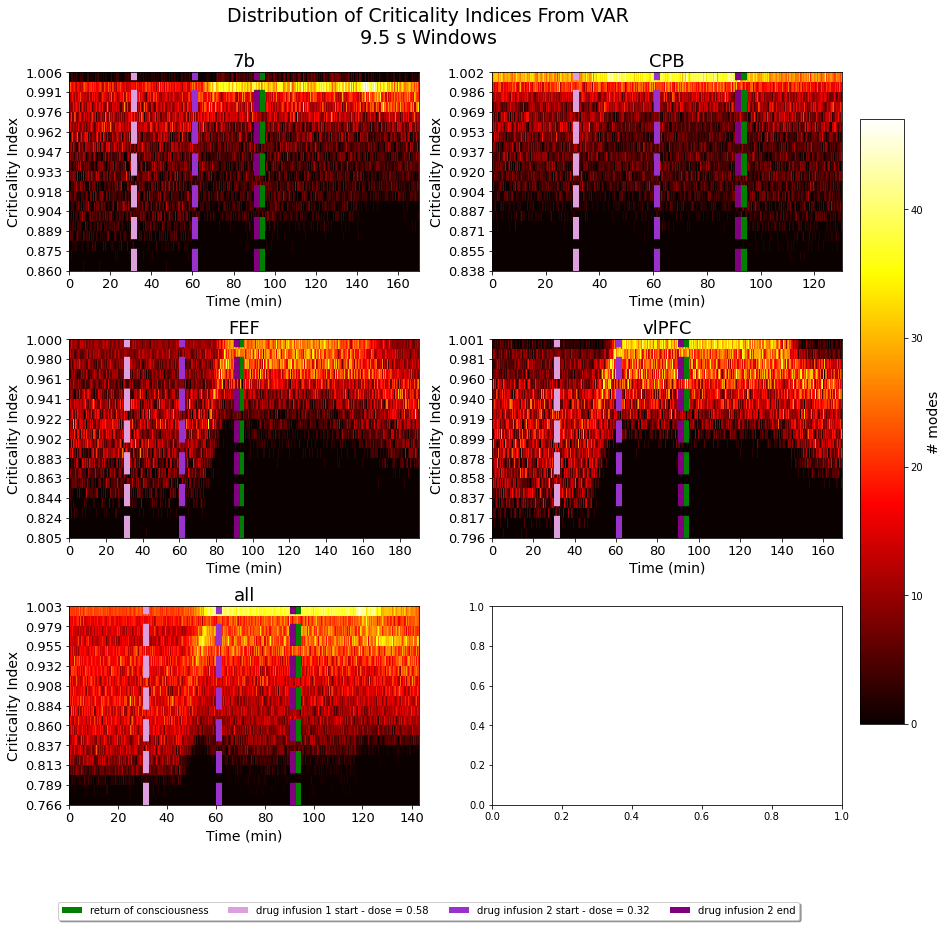

In [15]:
lw = 6
rows = 3
cols = 2
fig, axs = plt.subplots(rows, cols, figsize=(12, 12))
for i, area in enumerate(VAR_results.keys()):
    ax = axs[int(i/cols)][i % cols]
    
    bin_nums = 20
    bin_min = np.concatenate(VAR_results[area].criticality_inds.to_numpy()).min()
#     bin_min = 0.88
#     if area == 'all':
#         bin_min = 0.85
#     elif area == 'Thal':
#         bin_min = 0.98
    bin_max = np.concatenate(VAR_results[area].criticality_inds.to_numpy()).max()
#     bin_max = 1.03
    if area == 'Thal':
        bin_max = 1.01
    bins = [(bin_max - bin_min)*i/bin_nums + bin_min for i in range(bin_nums + 1 )]
    criticality_prob_dist = np.zeros((VAR_results[area].criticality_inds.shape[0], bin_nums))
    for t in range(VAR_results[area].criticality_inds.shape[0]):
        criticality_prob_dist[t] = np.histogram(VAR_results[area].criticality_inds[t], bins=bins)[0]

    im = ax.pcolormesh(criticality_prob_dist.T, cmap='hot')
    start_times = np.arange(VAR_results[area].criticality_inds.shape[0])*stride/60
    T_max = VAR_results[area].criticality_inds.shape[0]*stride/60
    ax.set_xticks([int(i*60/stride) for i in np.arange(0, T_max, 20)], [int(i) for i in np.arange(0, T_max, 20)])
    ax.set_yticks(np.arange(0, 21, 2), [f"{b:.3f}" for b in np.array(bins)[np.arange(0, 21, 2)]])
    ax.tick_params(labelsize=13)
    ax.set_xlabel("Time (min)", fontsize=14)
    ax.set_ylabel("Criticality Index", fontsize=14)
    ax.set_title(f"{area}", fontsize=18)
#     ax.axvline(session_info['eyesClose'][-1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose'], linestyle='--', lw=lw, c='red', label="loss of consciousness")
    ax.axvline(session_info['eyesOpen'][-1]/stride if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']/stride, linestyle='--', lw=lw, c='green', label="return of consciousness")
    ax.axvline(session_info['drugStart'][0]/stride, color='plum', linestyle='--', lw=lw, label=f"drug infusion 1 start - dose = {session_info['drugDose'][0]}")
    ax.axvline(session_info['drugStart'][1]/stride, color='darkorchid', linestyle='--', lw=lw, label=f"drug infusion 2 start - dose = {session_info['drugDose'][1]}")
    ax.axvline(session_info['drugEnd'][1]/stride, color='purple', linestyle='--', lw=lw, label=f"drug infusion 2 end")
    handles, labels = ax.get_legend_handles_labels()
    # ax.fill_between(np.arange(session_info['drugStart'][1], session_info['drugEnd'][1], stride)/60, 
    #     min_val, max_val, color='darkorchid', alpha=0.2, label=f"drug infusion 1 - dose = {session_info['drugDose'][1]}")
#     ax.legend(fontsize=14, loc='upper center', ncol=4, bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True)
#     plt.colorbar(label="Number of modes")

plt.suptitle(f"Distribution of Criticality Indices From VAR\n{window} s Windows", fontsize=19)
fig.tight_layout()
cbar_ax = fig.add_axes([1, 0.15, 0.05, 0.7])
cb = fig.colorbar(im, cax=cbar_ax)
cb.set_label(label='# modes', fontsize=14)
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True)
plt.show()

# Plot With Different Windows

## Load the selected windows differing by phase

In [7]:
VAR_all_results_dir = f"/om/user/eisenaj/ChaoticConsciousness/results/{data_class}/VAR"
regex = re.compile(f"{session}_selected_windows_phase")
matches = []
for file in os.listdir(VAR_all_results_dir):
    if regex.match(file):
        matches.append(file)

if len(matches) == 0:
    print(f"Window selection hasn't been run for session {session}")
elif len(matches) == 1:
    path_to_file = os.path.join(VAR_all_results_dir, matches[0])
    print(f"Loading file {path_to_file}")
    selected_windows = load(path_to_file)
else:
    steps = [int(file.split('_')[-2]) for file in matches]
    print(f"Selected windows are available for the following forward-step predictions (number of steps): \n{steps}")
    print("Which one would you like to use?")
    chosen_steps = input()
    chosen_steps = int(chosen_steps)
    ind = np.where(np.array(steps) == chosen_steps)[0]
    if len(ind) == 0:
        print(f"{chosen_steps} steps is not an option, try again")
        selected_windows = None
    else:
        ind = ind[0]
        path_to_file = os.path.join(VAR_all_results_dir, matches[ind])
        print(f"Loading file {path_to_file}")
        selected_windows = load(path_to_file)

Loading file /om/user/eisenaj/ChaoticConsciousness/results/propofolPuffTone/VAR/Mary-Anesthesia-20160809-01_selected_windows_phases_10_steps


In [8]:
slice_funcs = dict(
    pre=lambda window: slice(0, int(session_info['drugStart'][0]/window)),
    during=lambda window: slice(int(session_info['drugStart'][0]/window), int(session_info['drugEnd'][1]/window)),
    post=lambda window: slice(int(session_info['drugEnd'][1]/window),-1)
)

In [9]:
window_info = {}
for phase in selected_windows.keys():
    for area, window in selected_windows[phase].items():
        window = int(window) if window % 1 == 0 else window
        if window not in window_info.keys():
            window_info[window] = []
        window_info[window].append((area, phase))

In [10]:
VAR_results = {}
for area in selected_windows['pre'].keys():
    if area == 'all':
        VAR_results[area] = {'start_time': [], 'criticality_inds': [], 'A_mat': []}
    else:
        VAR_results[area] = {'start_time': [], 'criticality_inds': []}

for window in window_info.keys():
    stride = window
    areas_to_load = np.unique([entry[0] for entry in window_info[window]])
    VAR_results_dir = get_result_path(VAR_all_results_dir, session, window, stride)
    
    temp_results = {}
    for area in areas_to_load:
        print(f"Now attempting to load area {area} with window {window}")
        try:
            temp_results[area] = load(os.path.join(VAR_results_dir, area))
        except IsADirectoryError:
            print(f"Need to compile {os.path.join(VAR_results_dir, area)}")
            # compile results
            temp_results[area] = compile_folder(os.path.join(VAR_results_dir, area))
    
    for (area, phase) in window_info[window]:
        VAR_results[area]['criticality_inds'].extend(temp_results[area]['criticality_inds'].iloc[slice_funcs[phase](window)])
        VAR_results[area]['start_time'].extend(temp_results[area]['start_time'].iloc[slice_funcs[phase](window)])
        if area == 'all':
            VAR_results[area]['A_mat'].extend(temp_results[area]['A_mat'].iloc[slice_funcs[phase](window)]) 

Now attempting to load area 7b with window 5
Now attempting to load area 7b with window 8.5
Now attempting to load area CPB with window 8.5
Now attempting to load area FEF with window 4
Now attempting to load area CPB with window 6.5
Now attempting to load area all with window 6.5
Now attempting to load area vlPFC with window 6.5
Now attempting to load area 7b with window 7
Now attempting to load area vlPFC with window 7
Now attempting to load area CPB with window 10
Now attempting to load area FEF with window 8
Now attempting to load area all with window 8
Now attempting to load area FEF with window 5.5
Now attempting to load area all with window 9.5


In [11]:
for area in VAR_results.keys():
    VAR_results[area] = pd.DataFrame(VAR_results[area]).sort_values('start_time').reset_index(drop=True)

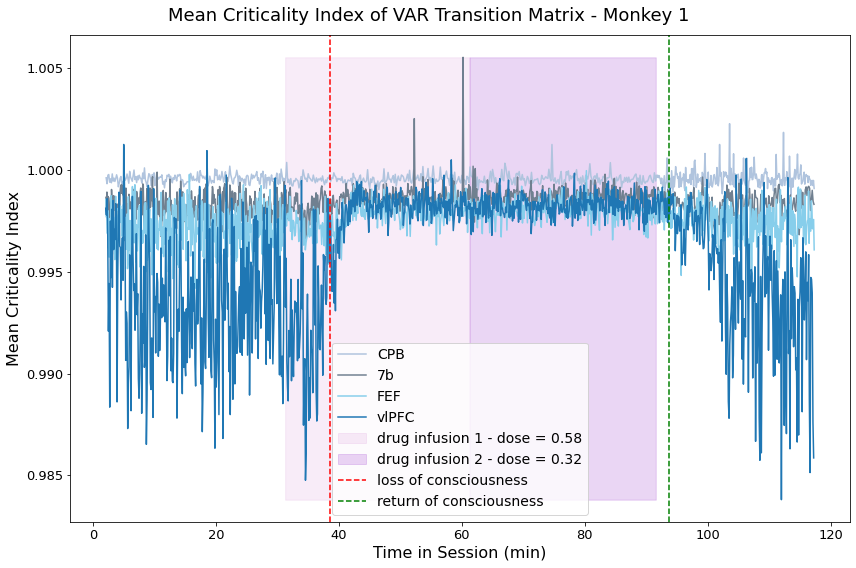

In [12]:
plot_individual_areas(session, data_class, VAR_results, session_info, start_time=125, end_time=None)

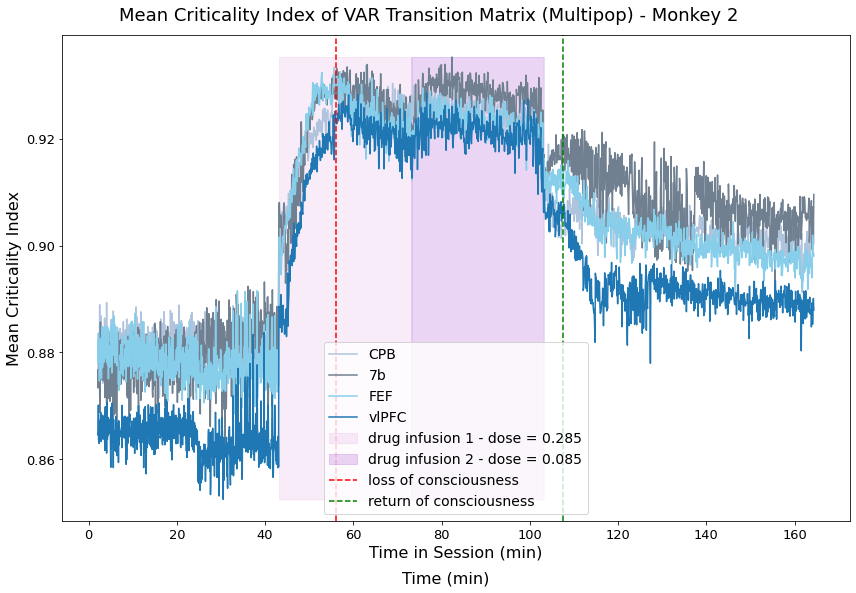

In [31]:
plot_multipopulation(session, data_class, VAR_results, session_info, electrode_info, start_time=125, end_time=None)

## Load the selected windows

In [18]:
VAR_all_results_dir = f"/om/user/eisenaj/ChaoticConsciousness/results/{data_class}/VAR"
regex = re.compile(f"{session}_selected_windows_*[0-9]")
matches = []
for file in os.listdir(VAR_all_results_dir):
    if regex.match(file):
        matches.append(file)

if len(matches) == 0:
    print(f"Window selection hasn't been run for session {session}")
elif len(matches) == 1:
    path_to_file = os.path.join(VAR_all_results_dir, matches[0])
    print(f"Loading file {path_to_file}")
    selected_windows = load(path_to_file)
else:
    steps = [int(file.split('_')[-2]) for file in matches]
    print(f"Selected windows are available for the following forward-step predictions (number of steps): \n{steps}")
    print("Which one would you like to use?")
    chosen_steps = input()
    chosen_steps = int(chosen_steps)
    ind = np.where(np.array(steps) == chosen_steps)[0]
    if len(ind) == 0:
        print(f"{chosen_steps} steps is not an option, try again")
        selected_windows = None
    else:
        ind = ind[0]
        path_to_file = os.path.join(VAR_all_results_dir, matches[ind])
        print(f"Loading file {path_to_file}")
        selected_windows = load(path_to_file)
# selected_windows = 

Loading file /om/user/eisenaj/ChaoticConsciousness/results/propofolPuffTone/VAR/MrJones-Anesthesia-20160301-01_selected_windows_10_steps


In [19]:
windows = np.unique(list(selected_windows.values()))
windows = [int(w) if w % 1 == 0 else w for w in windows ]

In [20]:
VAR_results = {}

for window in windows:
    stride = window
    VAR_results_dir = get_result_path(VAR_all_results_dir, session, window, stride)

    for area, value in selected_windows.items():
        if value == window:
            print(f"Attempting to load area {area} with window {window}")
            try:
                VAR_results[area] = load(os.path.join(VAR_results_dir, area))
            except IsADirectoryError:
                print(f"Need to compile {os.path.join(VAR_results_dir, area)}")
                # compile results
                VAR_results[area] = compile_folder(os.path.join(VAR_results_dir, area))

Attempting to load area FEF with window 3
Attempting to load area 7b with window 3.5
Attempting to load area vlPFC with window 3.5
Attempting to load area CPB with window 4
Attempting to load area all with window 4


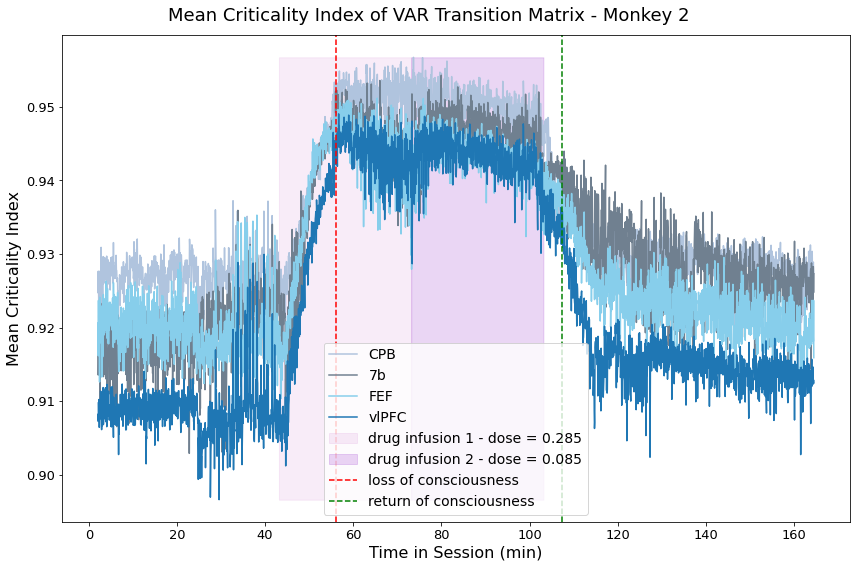

In [21]:
plot_individual_areas(session, data_class, VAR_results, session_info, start_time=125, end_time=None)

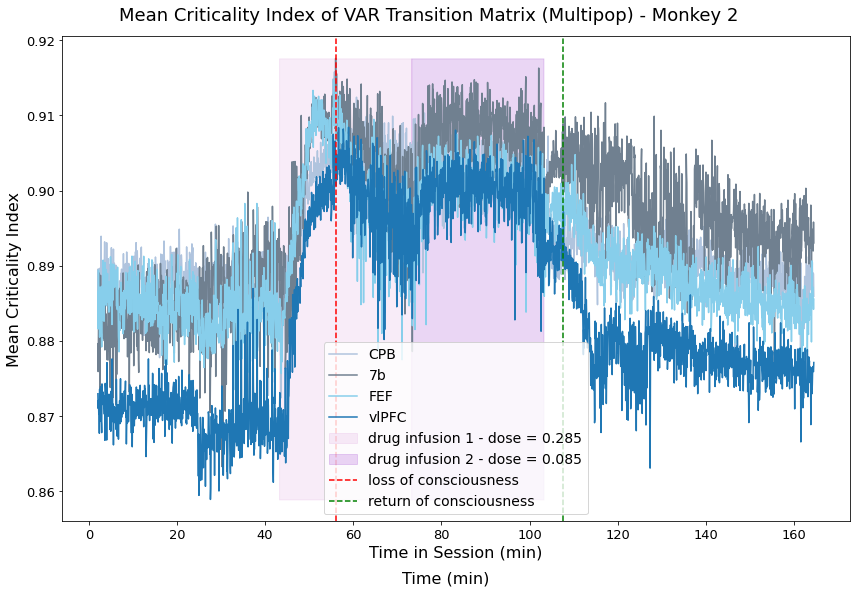

In [22]:
plot_multipopulation(session, data_class, VAR_results, session_info, electrode_info, start_time=125, end_time=None)

# Test

In [23]:
i = 0
area = 'all'

In [24]:
unit_indices = run_params['unit_indices'][area]
T_pred = 25
row = results[area].iloc[i]
x0 = lfp[row.start_step + int(run_params['window']/dt) - 1, unit_indices]
predictions = np.zeros((T_pred, len(unit_indices)))
for t in range(T_pred):
    if t == 0:
        predictions[t] = np.concatenate([[1], x0]) @ row.A_mat_with_bias
    else:
        predictions[t] = np.concatenate([[1], predictions[t-1]]) @ row.A_mat_with_bias

NameError: name 'run_params' is not defined

In [ ]:
unit_num = 2
plt.plot(np.concatenate([[x0], predictions])[:, unit_num], label='predicted')
plt.plot(lfp[row.start_step + int(run_params['window']/dt) - 1:row.start_step + int(run_params['window']/dt) + T_pred, unit_indices[unit_num]], label='true')
plt.xlabel('Time (ms)', fontsize=14)
plt.ylabel('LFP (mV)', fontsize=14)
ax = plt.gca()
ax.tick_params(labelsize=13)
plt.legend()
plt.show()